# **Mercari Price Suggestion Challenge**

**I. Tổng quan về dữ liệu**

**1. Mô tả bài toán**

Mercari Price suggestion là cuộc thi dự đoán một mặt hàng- thực sự đáng giá bao nhiêu. Chi tiết nhỏ có thể có nghĩa là sự khác biệt lớn về giá cả. Ví dụ, một trong những chiếc áo len có giá 335 đô la và chiếc còn lại có giá 9,99 đô la thì điều gì quyết định về giá của sản phẩm.

Việc định giá sản phẩm thậm chí còn khó hơn trên quy mô lớn, chỉ cần xem xét có bao nhiêu sản phẩm được bán trực tuyến. Quần áo có xu hướng định giá theo mùa mạnh mẽ và bị ảnh hưởng nhiều bởi thương hiệu, trong khi đồ điện tử có giá dao động dựa trên thông số kỹ thuật của sản phẩm. 

Mercari muốn đưa ra đề xuất về giá cho người bán, nhưng điều này rất khó vì người bán của họ được phép đưa bất kỳ thứ gì hoặc bất kỳ gói nào lên thị trường của Mercari.

Input: Dữ liệu dạng text gồm name, **item_condition**, **category**, **brand_name**, **shippin**g và **item_description** về sản phẩm.

Output: Giá của sản phẩm.

**2. Cấu trúc của dữ liệu**

Import thư viện và giải nén

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z
!unzip /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

**3. Phân tích dữ liệu**


In [ ]:
#Đọc dữ liệu từ 2 tập train.tsv và test_stg2.tsv và đưa về dạng bảng
train_data = pd.read_table("train.tsv")
test_data = pd.read_table("test_stg2.tsv")


In [ ]:
#Kiểm tra thông tin của tệp train
train_data.info()
test_data.info()

Tập dữ liệu này chứa 1482535 mẫu, có thể coi là đủ lớn cho một mô hình học máy. Lưu ý rằng, các thuộc tính category_name, brand_name và item_desciption có các giá trị null và ta sẽ cần xử lý vấn đề này.
Dữ liệu bao gồm:

1. 2 thuộc tính dạng văn bản là name và **item_description**.
2. 2 thuộc tính dạng nhãn là **category_name** và **brand_name**.
3. 2 thuộc tính có giá trị số là **item_condition_id** và **shipping**, nhưng chúng vẫn thuộc kiểu dữ liệu dạng nhãn.
price có giá trị số thực.

In [ ]:
print(train_data.shape)
print(test_data.shape)

Nhận xét :

1. Tập train gồm 8 cột thông tin về sản phẩm và có tổng cộng 1482535 sản phẩm
2. Tập test gồm 3460725 sản phẩm, có 7 cột thông tin và ta dự vào đó để tìm ra 'price' của sản phẩm

In [ ]:
train_data.head()

Tổng quan về dữ liệu.
Trong tập train ta có 8 trường thông tin dữ liệu:

* **train_id** là chỉ số của sản phẩm
* **name id** tên của sản phẩm (dạng text)
* **item_condition_id** là tình trạng của các mặt hàng do người bán cung cấp. (dạng số 1-5)
* **category_name** là danh mục của sản phẩm
* **brand_name** là tên nhãn hiệu của sản phẩm
* **price** là giá của sản phẩm và đây cũng là mục tiêu của bài toán này
* **shipping** là sản phẩm này có được vận chuyển đến nhà (dạng số 0/1)
* **item_description** là mô tả thông tin sản phẩm (dạng văn bản) Dữ liệu đã được làm sạch để xóa văn bản trông giống như giá (ví dụ: 20) để tránh rò rỉ. Các giá bị loại bỏ này được biểu thị là [rm]

Nhận xét:
* Ở tập train, mỗi 1 sản phấm sẽ có các thuộc tính: train_id, name, item_condition_id, category_name, shipping, item_description và cột price
* Ở cột brand_name có nhiều giá trị NaN(giá trị rỗng)

**3. Chi tiết về từng thuộc tính**


***Price***

In [ ]:
# Đồ thị phân phối Price
plt.figure(figsize=(7, 7))
sns.histplot(train_data['price'], kde=False, stat="density", linewidth=0)
plt.show()

In [ ]:
#Biểu diễn đồ thị một cách dễ nhìn hơn, kèm theo phân phối chuẩn maximum likelihood
from scipy.stats import norm
plt.figure(figsize=(7, 7))
ax = sns.distplot(train_data['price'], fit=norm, kde=False)
ax.set_xlim(0, 250)
plt.show()

In [ ]:
#thu hẹp khoảng giá trị để biểu diễn trên log cho dễ quan sát
plt.figure(figsize=(7, 7))
sns.distplot(np.log1p(train_data['price']), fit=norm, kde=False)
plt.show()

In [ ]:
#Chỉ lấy các price > 0 và loại bỏ price<=0(vì các sản phẩm không có ý nghĩa khi price <=0)
train_data = train_data[train_data['price'] > 0].reset_index(drop = True)
# train, validation = train_test_split(train_data, test_size = 0.1, random_state = 30)
train = train_data.copy()
test = test_data.copy()
print(train.shape)
print(test.shape)

In [ ]:
train.price.describe().apply(lambda x: format(x, 'f'))

In [ ]:

unique_brands = train['brand_name'].value_counts()
print("Số nhãn hiệu phân biệt là {}".format(len(unique_brands)))
plt.figure(figsize=(20, 5))
sns.barplot(unique_brands.index[1:11], unique_brands[1:11])
plt.title('Top 10 các nhãn hiệu và số lượng sản phẩm của từng thương hiệu')
plt.xlabel('Tên các nhãn hiệu')
plt.ylabel('Số lượng sản phẩm')
plt.show()

Nhận xét: 
1. Nike và Victoria's Secret là 2 thương hiệu có số lượng sản phẩm lớn nhất.
2. Thương hiệu sản phẩm ảnh hưởng tới giá của từng sản phẩm.

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(train['price'], bins=50, range=[0, 200], edgecolor='white')
plt.title('Phân phối của giá sản phẩm')
plt.xlabel('Price(Giá)')
plt.ylabel('Số sản phẩm')
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['price']), bins=50, edgecolor='white')
plt.title('Phân phối của Log(Price)')
plt.xlabel('Log(Price)')
plt.ylabel('Số lượng sản phẩm')
plt.show()
# sns.displot(np.log1p(train['price']))

**Các thuộc tính dãn nhãn**

In [ ]:
sns.distplot(train['price'])

In [ ]:
train['price'] = np.log1p(train['price'])
sns.distplot(train['price'])

**Item_condition_id**

In [ ]:
train['item_condition_id'].value_counts()

In [ ]:
count = train['item_condition_id'].value_counts()
plt.figure(figsize=(15, 5))
sns.barplot(count.index[:5], count[:5])
plt.ylabel('Số lượng sản phẩm')
plt.xlabel('Điều kiện sản phẩm')

**Shipping**

In [ ]:
train['shipping'].value_counts()

In [ ]:
count = train['shipping'].value_counts()
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
sns.barplot(count.index, count)
plt.xlabel('Shipping')
plt.ylabel('Số sản phẩm')
plt.subplot(1, 2, 2)
labels = ['Không Ship', 'Có Ship']
sizes = count
colors = ['green', 'yellow']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

**Item_description**

Kiểm tra biến item_description

In [ ]:
train['item_description'].value_counts().head()

**Category**

In [ ]:
print(train['category_name'].nunique())

In [ ]:
train['category_name'].value_counts().head(10)

In [ ]:
train['category_name'].isnull().sum()

**II. Xử lý dữ liệu**

**Làm sạch dữ liệu**

Xử lý column *Category_name*

In [ ]:
def category_split(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Missing', 'Missing', 'Missing']
train['main_cat'], train['sub_cat'], train['item_cat'] = zip(*train['category_name'].apply(lambda x: category_split(x)))
test['main_cat'], test['sub_cat'], test['item_cat'] = zip(*test['category_name'].apply(lambda x: category_split(x)))

Xử lý giá trị Null

In [ ]:
def fill(data):
    data['category_name'].fillna('Missing', inplace = True)
    data['brand_name'].fillna('Missing', inplace = True)
    data['item_description'].fillna('Missing', inplace = True)
    return data

fill(train)
fill(test)

***Kiểm tra lại sau khi đã làm sạch***

In [ ]:
train.head()

In [ ]:
train.nunique()

Nhận xét:
1. giá trị ở name và item_description lớn hơn hẳn các cột khác
2. Cần vector hóa name và item_description
3. Phân loại theo lable các features

**Vector hóa dữ liệu**

In [ ]:
# Quy đổi time
import time
def format_time(seconds):
    days = int(seconds / 3600 / 24)
    seconds = seconds - days * 3600 * 24
    hours = int(seconds / 3600)
    seconds = seconds - hours * 3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes * 60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds * 1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

**Vector hóa name column**

Sử dụng mô hình BoW(Bag-of-words)
Mô hình túi từ (bag-of-words) là một biểu diễn đơn giản hóa được sử dụng trong xử lý ngôn ngữ tự nhiên và truy vấn thông tin (IR). Trong mô hình này, một văn bản (chẳng hạn như một câu hoặc một tài liệu) được thể hiện dưới dạng túi (multiset) chứa các từ của nó, không quan tâm đến ngữ pháp và thậm chí trật tự từ nhưng vẫn giữ tính đa dạng.

Mô hình túi từ thường được sử dụng trong các phương pháp phân loại tài liệu trong đó sự xuất hiện (tần suất) của mỗi từ được sử dụng như một đặc trưng để đào tạo máy phân loại.



In [ ]:
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

**Vectơ hóa Item_Description Column**

Sử dụng mô hình **TF-IDF** (Term Frequency – Inverse Document Frequency)
là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản.

TF: Term Frequency(Tần suất xuất hiện của từ) là số lần từ xuất hiện trong văn bản. Trong các văn bản thì tần suất xuất hiện của các từ có thể lớn hoặc nhỏ, TF sẽ chia độ dài văn bản (theo số từ)

IDF: Inverse Document Frequency(Nghịch đảo tần suất của văn bản), nhằm đánh giá giá trị của các từ. Khi tính toán TF , tất cả các từ được coi như có độ quan trọng bằng nhau. Nhưng một số từ ngắn như "is" "a" "or"... thường xuất hiện nhiều nhưng giá trị không lớn => IDF sẽ giảm giá trị đánh giá các từ này.

In [ ]:
start_time = time.time()
cnt_vec = CountVectorizer()

X_train_name = cnt_vec.fit_transform(train['name'])
X_test_name = cnt_vec.transform(test['name'])
print('Name Completed: {}'.format(format_time(time.time() - start_time)))
print(X_train_name.shape)
print(X_test_name.shape)

In [ ]:
start_time = time.time()
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')

X_train_descp = tfidf_descp.fit_transform(train['item_description'])
X_test_descp = tfidf_descp.transform(test['item_description'])
print('Item Description Completed: {}'.format(format_time(time.time() - start_time)))

In [ ]:
train.head()

**Phân loại các features thông qua LabelBinarizer**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
start_time = time.time()

lb_brand_name = LabelBinarizer(sparse_output=True)
X_train_brand = lb_brand_name.fit_transform(train['brand_name'])
X_test_brand = lb_brand_name.transform(test['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_train_item_condition_id = lb_item_cond_id.fit_transform(train['item_condition_id'])
X_test_item_condition_id = lb_item_cond_id.transform(test['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_train_shipping = lb_shipping.fit_transform(train['shipping'])
X_test_shipping = lb_shipping.transform(test['shipping'])

print('Complete in: {}'.format(format_time(time.time() - start_time)))

In [ ]:
start_time = time.time()

lb_main_cat = LabelBinarizer(sparse_output=True)
X_train_main_cat = lb_main_cat.fit_transform(train['main_cat'])
X_test_main_cat = lb_main_cat.transform(test['main_cat'])

lb_sub_cat = LabelBinarizer(sparse_output=True)
X_train_sub_cat = lb_sub_cat.fit_transform(train['sub_cat'])
X_test_sub_cat = lb_sub_cat.transform(test['sub_cat'])

lb_item_cat = LabelBinarizer(sparse_output=True)
X_train_item_cat = lb_item_cat.fit_transform(train['item_cat'])
X_test_item_cat = lb_item_cat.transform(test['item_cat'])

print('Complete in: {}'.format(format_time(time.time() - start_time)))

In [ ]:
# Full dataframe printing
print(type(X_train_brand), type(X_train_item_condition_id), type(X_train_shipping))
print(type(X_test_brand), type(X_test_item_condition_id), type(X_test_shipping))

In [ ]:
# Train dataframe printing
print('X_train_brand shape:', X_train_brand.shape)
print('X_train_item_cond_id shape:', X_train_item_condition_id.shape)
print('X_train_shipping shape:', X_train_shipping.shape)
print('X_train_main_cat shape:', X_train_main_cat.shape)
print('X_train_sub_cat shape:', X_train_sub_cat.shape)
print('X_train_item_cat shape:', X_train_item_cat.shape)

In [ ]:
#  Test dataframe printing
print('X_test_brand shape:', X_test_brand.shape)
print('X_test_item_cond_id shape:', X_test_item_condition_id.shape)
print('X_test_shipping shape:', X_test_shipping.shape)
print('X_test_main_cat shape:', X_test_main_cat.shape)
print('X_test_sub_cat shape:', X_test_sub_cat.shape)
print('X_test_item_cat shape:', X_test_item_cat.shape)

**Xếp chồng các khối dữ liệu thành ma trận**

In [ ]:
from scipy.sparse import hstack
import gc

In [ ]:
sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

In [ ]:
X_train = hstack(sparse_matrix_list).tocsr()
print(type(X_train), X_train.shape)

In [ ]:
del X_train
gc.collect()

**Xây Dựng Các Mô Hình Học Máy Và Huấn Luyện Dữ Liệu**

**RMSLE**

Lỗi trung bình bình phương (RMSE) là độ lệch chuẩn của phần dư ( lỗi dự đoán ). ... Nó thực hiện điều này bằng cách đo sự khác biệt giữa các giá trị dự đoán và giá trị thực tế . R-MSE càng nhỏ tức là sai số càng bé thì mức độ ước lượng cho thấy độ tin cậy của mô hình có thể đạt cao nhất.
Công thức:
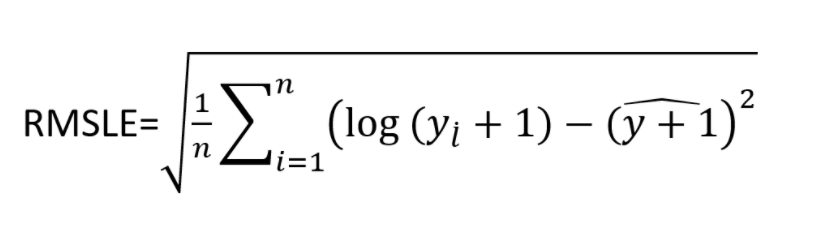


Trong đó:

* y^i là giá trị ước lượng
* yi là biến độc lập
* n=(N – k – 1)
* N : số tổng lượng quan sát
* K : tổng lượng biến

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_orig_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    return rmsle(y_test_exmpm, preds_exmpm)

In [ ]:
def model_train_predict(model, matrix_list):
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, train['price'], test_size=0.2)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

**Ridge Regression Model**

Tổng quan:

Hồi quy Ridge là một kỹ thuật để phân tích nhiều dữ liệu hồi quy chịu sự đa hình. Khi đa cộng tuyến xảy ra, ước tính bình phương tối thiểu là không thiên vị, nhưng phương sai của chúng lớn nên chúng có thể cách xa giá trị thực. Bằng cách thêm một mức độ sai lệch cho các ước tính hồi quy, hồi quy sườn giúp giảm các lỗi tiêu chuẩn.

Ridge Regression là mô hình hồi quy phân tích mối quan hệ giữa các biến độc lập và các biến phụ thuộc sử dụng phương pháp Regularization, điều chình mô hình sao cho giảm thiểu các vấn đề Overfitting, tối ưu hay kiểm soát mức độ phức tạp của mô hình để cân đối giữa Biased và Variance Quan đó giảm sai số của mô hình.

Công thức tổng quát của mô hình:


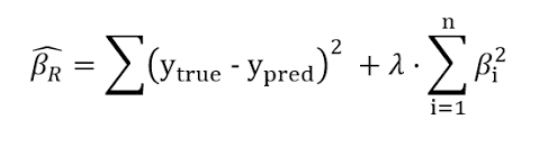


Hệ số λ hay còn gọi là tham số Regularization, là số luôn dương, là giá trị mà ở đó phương trình tuyến tính sẽ tính toán được để sai số của mô hình được giảm tối đa, nghĩa là giá trị λ nào làm cho MSE (ở đây dùng RLMSE) nhỏ nhất thì mô hình đó được chọn

In [ ]:
start_time = time.time()
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_train_name, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

linear_preds, y_test = model_train_predict(model=linear_model, 
                                           matrix_list=sparse_matrix_list)

print('Item Description rmsle:', evaluate_orig_price(y_test, linear_preds))

sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)


linear_preds, y_test = model_train_predict(model=linear_model, 
                                           matrix_list=sparse_matrix_list)
print('Item Description rmsle:', evaluate_orig_price(y_test, linear_preds))

print('Complete in: {}'.format(format_time(time.time() - start_time)))

**Result**

In [ ]:
sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

X_train = hstack(sparse_matrix_list).tocsr()
X_train

In [ ]:
sparse_matrix_list = (X_test_name, X_test_descp, X_test_brand, 
                      X_test_item_condition_id, X_test_shipping, 
                      X_test_main_cat, X_test_sub_cat, X_test_item_cat)
X_test = hstack(sparse_matrix_list).tocsr()

In [ ]:
y_train = train['price']
y_train

In [ ]:
linear_model.fit(X_train, y_train)

In [ ]:
preds = linear_model.predict(X_test)
preds

In [ ]:
preds = np.expm1(preds)
preds

**Lasso Regression**

Một mô hình anh em với Ridge là Laso, thay vì Ridge sử dụng công thức chuẩn hóa L2 khi tìm hệ số w thì Laso sử dụng công thức chuẩn hóa L1. Sử dụng công thức chuẩn hóa L1 nhằm mục đích loại bớt feature ít ảnh hưởng tới đầu ra nghĩa là làm cho phần lớn các trọng số w = 0.

In [ ]:
sparse_matrix_list = (X_train_name, X_train_descp, X_train_brand, 
                      X_train_item_condition_id, X_train_shipping, 
                      X_train_main_cat, X_train_sub_cat, X_train_item_cat)

train_X = hstack(sparse_matrix_list).tocsr()
train_Y = train_data["price"]
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_Y, test_size=0.1, random_state=42)
def evaluation(model):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_validation)
    train_score = rmsle(np.expm1(train_pred), y_train)
    validation_score = rmsle(np.expm1(val_pred), y_validation)
    print("Evaluation ---- Training Dataset Score: {}, Validation Dataset Score: {}".format(train_score, validation_score))
    return train_score, validation_score

def train(model):
    X, y = X_train, np.log1p(y_train)
    model.fit(X, y)
    evaluation(model)
    return model

In [ ]:
lasso_model = Lasso(alpha=1e-06, fit_intercept=False)
lasso_model = train(lasso_model)

**LightGBM**

LightGBM viết tắt của Light Gradient Boosting Machine, là mã nguồn mở xử lý thuật toán tăng cường độ dốc (Gradient Boosting) được phát triển bởi Microsoft. Gradient Boosting là một thuật toán xuất phát từ thuật toán Cây quyết định (Decision Tree), nó thực hiện việc xây dựng tuần tự nhiều Cây quyết định và tiến hành học tập.

In [ ]:
import lightgbm as lgb
params = {
    'learning_rate': 0.75,
    'application': 'regression',
    'max_depth': 3,
    'num_leaves': 100,
    'verbosity': -1,
    'metric': 'RMSE',
}
d_train = lgb.Dataset(X_train, label=np.log1p(y_train))
d_valid = lgb.Dataset(X_validation, label=np.log1p(y_validation))
watchlist = [d_train, d_valid]

lgbm_model = lgb.train(
    params, 
    train_set=d_train, 
    num_boost_round=2200, 
    valid_sets=watchlist, 
    early_stopping_rounds=50, 
    verbose_eval=100
)

**So sánh kết quả**

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Train RMSLE", "Validation RMSLE"]
table.add_row(["Ridge Regression", 0.497253, 0.464687])
table.add_row(["Lasso Regression", 0.439915, 0.456478])
table.add_row(["LightGBM", 0.438928, 0.45633])
print(table)

**Chuẩn bị Submission**

In [ ]:
submission: pd.DataFrame = test[['test_id']]
submission['price'] = preds
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()